# Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [2]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

In [3]:
fs, x_prbs15 = scipy.io.wavfile.read("../app/sound/prbs15.wav")
print("Sample rate: {:.0f}".format(fs))

Sample rate: 44100


In [31]:
FIG_WIDTH = 8
H_XLIM = [0.1, 20e3]
H_YLIM = [-50, 10]

def plot_frequency_response(b, a, ax=None):
    if ax is None:
        ax = gca()
        
    f, H = signal.freqz(b, a)
    f *= fs/2/pi
    ax.semilogx(f, 20*log10(abs(H)))

def prbs_analyze(x, y, fs, h_length):
    # Estimate impulse response using a pseudo-random bit sequence.
    h = signal.correlate(y, x, "full")
    h = h[len(h)//2:]
    
    # Limit the impulse response length to lower the noise
    h = h[0:h_length]
    t = arange(h_length)/fs

    # Estimate frequency response
    H = fft.fft(h)
    H = H[0:len(H)//2] 
    H /= max(abs(H))
    f = linspace(0.01, fs/2, len(H))
    
    return t, h, f, H

def show_impulse_response(t, h, ax=None):
    if ax is None:
        ax = gca()

    ax.plot(t, real(h))

def show_frequency_response(f, H, ax=None):
    if ax is None:
        ax = gca()

    ax.semilogx(f, 20*log10(abs(H)))
    
    ax.grid(True)
    ax.set_xlim(*H_XLIM)
    ax.set_ylim(*H_YLIM)

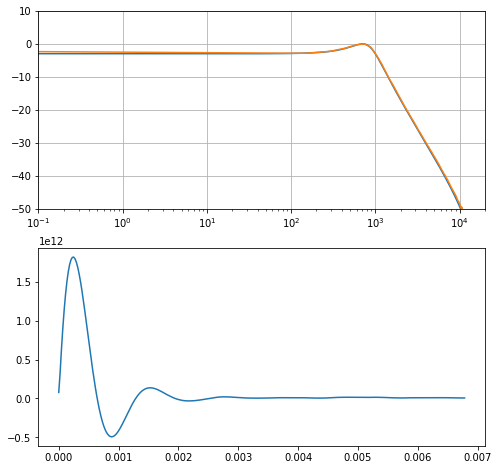

In [33]:
# Example filter
fig, (ax1, ax2) = subplots(2, 1, figsize=[FIG_WIDTH, 8])

# Analyzing coefficients with Scipy
b, a = signal.cheby1(2, 3, 1000 * 2/fs, btype="low")
plot_frequency_response(b, a, ax=ax1)

# Analyzing the filter with a PRBS measurement
y = signal.lfilter(b, a, x_prbs15)
t, h, f, H = prbs_analyze(x_prbs15, y, fs, 300)

show_frequency_response(f, H, ax=ax1)
show_impulse_response(t, h, ax=ax2)

# Zavalishin 2015 The Art of VA Filter Design

Ladder filter:
- Four single-pole filter, page 48.
- Feedback, page 63.

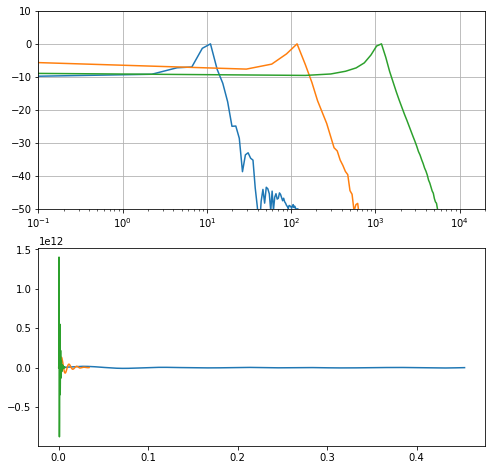

In [55]:
def ladder_zavalishin(x, g, k):
    y = zeros(len(x_prbs15))
    G = g/(1+g)

    w1 = [0, 0, 0, 0] # Delayed sum of y[n] and x[n]*G
    for n in range(1, len(y)):
        u = x[n] - y[n-1]*k

        # 1
        x_ = u
        v  = (x_-w1[0]) * G
        y_ = v + w1[0]
        w1[0] = y_ + v

        # 2
        x_ = y_
        v  = (x_-w1[1]) * G
        y_ = v + w1[1]
        w1[1] = y_ + v

        # 3
        x_ = y_
        v  = (x_-w1[2]) * G
        y_ = v + w1[2]
        w1[2] = y_ + v

        # 3
        x_ = y_
        v  = (x_-w1[3]) * G
        y_ = v + w1[3]
        w1[3] = y_ + v

        y[n] = y_

    return y

fig, (ax1, ax2) = subplots(2, 1, figsize=[FIG_WIDTH, 8])

x = x_prbs15

for g, k, h_length in [
        [0.001, 2, 20000],
        [0.01, 2, 1500],
        [0.1, 2, 300],
    ]:
    
    y = ladder_zavalishin(x, g=g, k=k)
    
    t, h, f, H = prbs_analyze(x, y, fs, h_length)
    show_frequency_response(f, H, ax=ax1)
    show_impulse_response(t, h, ax=ax2)


## ST AN3984 - IIR filter design equations for Sound Terminal devices

Not successful.

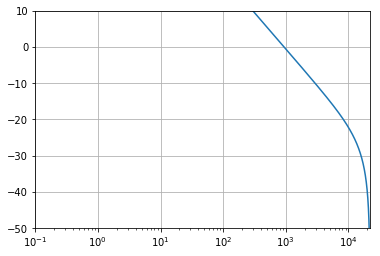

In [100]:
fc = 1000
Q = 2

wc = 2*pi*fc/fs
K = tan(wc/2)
alpha = 1+K

a = [0]*2
b = [0]*2

a[0] = 1
a[1] = -(1 + K)/alpha

b[0] = K/alpha
b[1] = K/alpha

plot_frequency_response(b, a)